In [1]:
import model,utils
import local_datasets
from simulator.simulator import GaussianSimulator
from simulator.utils import load_params
from simulator.init import init_probabilistically

import torch
from torch.utils.data import DataLoader 

from matplotlib import pyplot as plt

In [2]:
trainset = local_datasets.Character_Dataset(device='cpu', directory='./datasets/Characters',invert=False)
trainloader = DataLoader(trainset,batch_size=int(1),shuffle=True)

In [11]:
encoder = model.E2E_Encoder(in_channels=1, binary_stimulation=True).to('cpu')

params = load_params('simulator/config/params.yaml')
r, phi = init_probabilistically(params,n_phosphenes=1024)
realistic_simulator = model.E2E_RealisticPhospheneSimulator(params, r, phi)#.to(cfg.device)

displaying 20 degrees of vision in a resolution of [256, 256]
one degree is 12.8 pixels
0 phosphenes are outside of view, will not be shown


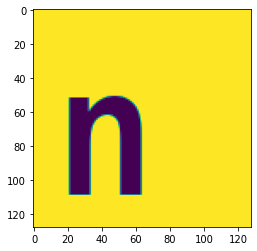

In [12]:
image, label = next(iter(trainloader))

plt.imshow(image[0][0])

In [13]:
stim = encoder(image)
proxy = 40e-6*torch.ones_like(stim,device='cpu')
img = realistic_simulator(proxy).cpu().numpy()

1024 out of 1 cross threshold
charge per second::
        size:   torch.Size([1, 1024])
        min:    2.04E-04
        max:    2.04E-04
        mean:   2.04E-04
        std:    4.37E-11
sigma (in pixels):
        size:   torch.Size([1, 1024])
        min:    1.35E+00
        max:    1.94E+01
        mean:   6.68E+00
        std:    4.95E+00
activation:
        size:   torch.Size([1, 1024])
        min:    2.04E-04
        max:    2.04E-04
        mean:   2.04E-04
        std:    4.37E-11
sigmoided activation:
        size:   torch.Size([1, 1024])
        min:    1.00E+00
        max:    1.00E+00
        mean:   1.00E+00
        std:    0.00E+00


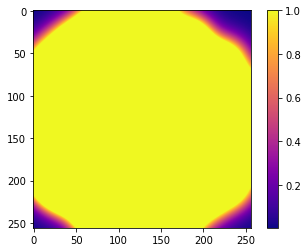

In [14]:
plt.imshow(img[0][0],cmap='plasma')
plt.colorbar()